[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 18541, number of used features: 7
[LightGBM] [Info] Start training from score 2800.671485
[100]	training's rmse: 625.777	valid_1's rmse: 654.755
[200]	training's rmse: 573.38	valid_1's rmse: 618.524
[300]	training's rmse: 542.524	valid_1's rmse: 603.4
[400]	training's rmse: 518.564	valid_1's rmse: 593.739
[500]	training's rmse: 499.69	valid_1's rmse: 587.745
[600]	training's rmse: 482.54	valid_1's rmse: 583.443
[700]	training's rmse: 468.631	valid_1's rmse: 581.12
[800]	training's rmse: 457.63	valid_1's rmse: 579.176
[900]	training's rmse: 448.24	valid_1's rmse: 578.617
[1000]	training's rmse: 438.842	valid_1's rmse: 578.29
Training Metrics: {'RMSE': 438.8416947814785, 'MAE'

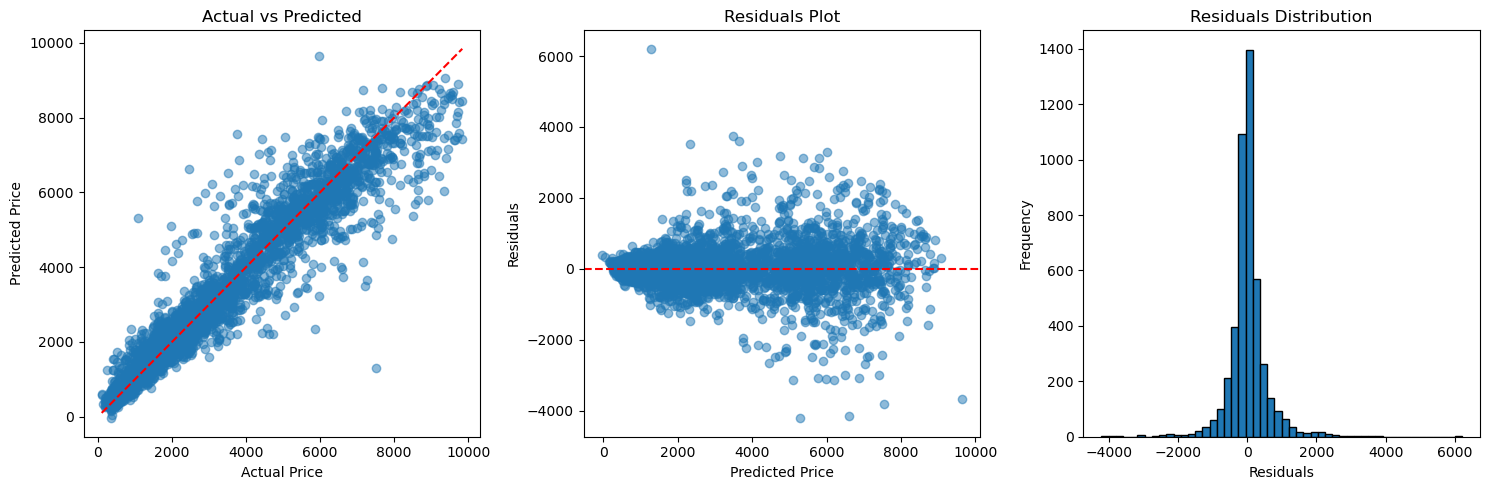

C:\Users\dzx_leanron\AppData\Local\Temp\ipykernel_5052\79880483.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['year', 'month']] = year_month_scaler.transform(X_test[['year', 'month']])


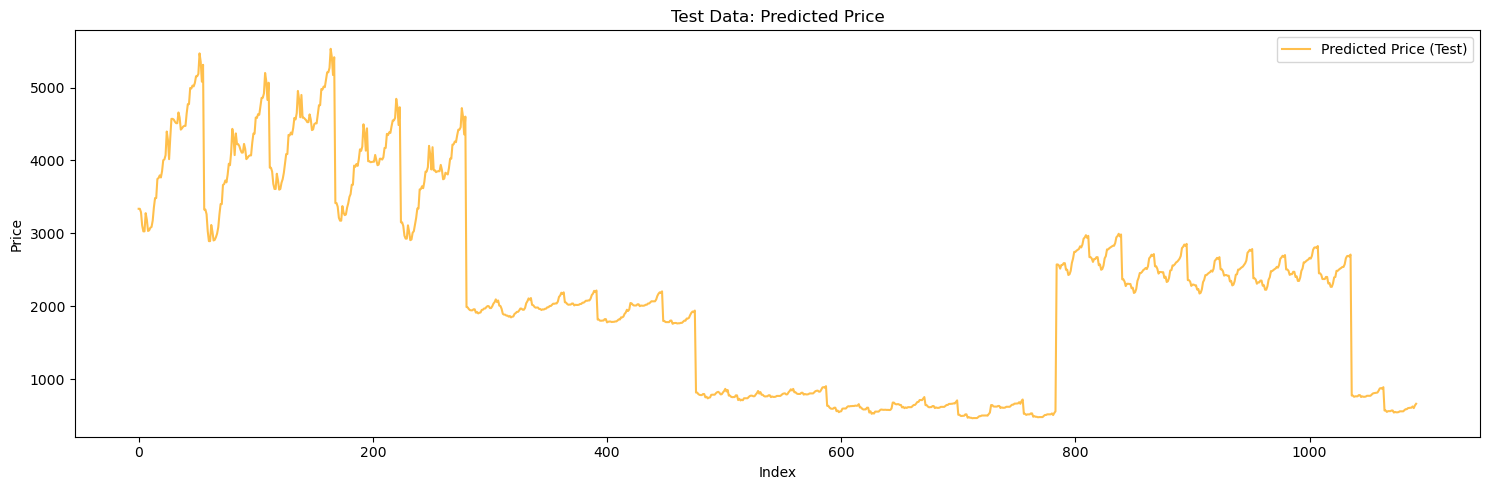


Test data prediction completed. Results saved in test_result.xlsx


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


def remove_outliers(df, column, threshold=3):
    """消除列中超过标准差threshold倍数的异常值，并删除目标值小于等于0的样本."""
    # 删除目标值小于等于0的样本
    if column == 'price(원/kg)':
        df = df[df[column] > 0]

    # 计算标准差和均值
    mean = df[column].mean()
    std = df[column].std()
    lower_limit = mean - threshold * std
    upper_limit = mean + threshold * std

    # 返回去除异常值后的数据
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]


def fill_supply_in_test_data(test_data, train_data):
    """
    填充测试集中缺失的'supply(kg)'特征

    参数:
    test_data (DataFrame): 测试数据集
    train_data (DataFrame): 训练数据集

    返回:
    test_data (DataFrame): 填充后的测试数据集
    """
    # 对测试集按年和月分组
    for idx, row in test_data[test_data['supply(kg)'].isnull()].iterrows():
        # 找出训练集中相同年份和月份的数据
        matching_train_rows = train_data[
            (train_data['timestamp'].dt.year == row['timestamp'].year) &
            (train_data['timestamp'].dt.month == row['timestamp'].month)
            ]

        if not matching_train_rows.empty:
            # 按与测试集数据日期的接近程度排序
            matching_train_rows['date_diff'] = abs((matching_train_rows['timestamp'].dt.day - row['timestamp'].day))

            # 按日期差异升序排列，选择最接近的记录
            closest_row = matching_train_rows.sort_values('date_diff').iloc[0]

            # 填充'supply(kg)'
            test_data.loc[idx, 'supply(kg)'] = closest_row['supply(kg)']
        else:
            # 如果没有相同年月的数据，使用全局平均值
            test_data.loc[idx, 'supply(kg)'] = train_data['supply(kg)'].mean()

            # 检查是否还有缺失值
    if test_data['supply(kg)'].isnull().sum() > 0:
        print("Warning: Some 'supply(kg)' values still missing after filling")

    return test_data


def preprocess_data(file_path):
    # 加载数据
    data = pd.read_excel(file_path)

    # 清除异常值并删除目标值小于等于0的样本
    data = remove_outliers(data, 'price(원/kg)')
    data = remove_outliers(data, 'supply(kg)')

    # 类别型特征编码
    categorical_columns = ['item', 'corporation', 'location']
    encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        encoders[col] = le

    # 提取日期特征
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['dayofyear'] = data['timestamp'].dt.dayofyear

    return data, encoders


# 准备训练数据
def prepare_data(data):
    # 创建MinMaxScaler
    year_month_scaler = MinMaxScaler()

    # 构造特征和标签
    features = ['item', 'corporation', 'location', 'supply(kg)', 'year', 'month', 'dayofyear']

    # 划分训练集和验证集
    X = data[features]
    y = data['price(원/kg)']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 对年份和月份进行归一化
    X_train[['year', 'month']] = year_month_scaler.fit_transform(X_train[['year', 'month']])
    X_val[['year', 'month']] = year_month_scaler.transform(X_val[['year', 'month']])

    return X_train, X_val, y_train, y_val, year_month_scaler


def estimate_supply_for_test_data(test_data, train_data):
    """
    根据训练集数据估算测试集的供应量

    参数:
    test_data (DataFrame): 测试数据集
    train_data (DataFrame): 训练数据集

    返回:
    test_data (DataFrame): 添加估算供应量的测试数据集
    """
    # 将训练数据按照条目(item)、公司(corporation)、位置(location)分组
    train_supply_groups = train_data.groupby(['item', 'corporation', 'location'])['supply(kg)']

    def estimate_supply(row):
        # 查找匹配的组
        group_key = (row['item'], row['corporation'], row['location'])

        # 首选精确匹配
        try:
            group_supply = train_supply_groups.get_group(group_key)
            return group_supply.mean()
        except KeyError:
            # 如果没有精确匹配，尝试部分匹配
            # 例如只匹配item和location
            partial_match = train_data[
                (train_data['item'] == row['item']) &
                (train_data['location'] == row['location'])
                ]['supply(kg)']

            if not partial_match.empty:
                return partial_match.mean()

                # 如果没有部分匹配，使用全局平均值
            return train_data['supply(kg)'].mean()

            # 为测试集添加估算的供应量

    test_data['supply(kg)'] = test_data.apply(estimate_supply, axis=1)

    return test_data


# 训练LightGBM模型
def train_lightgbm_model(X_train, y_train, X_val, y_val):
    # 创建LightGBM数据集
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # 模型参数
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    # 训练模型
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        num_boost_round=1000,
        callbacks=[lgb.callback.log_evaluation(period=100)]
    )

    return model


# 评估模型性能
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # 预测
    train_predictions = model.predict(X_train, num_iteration=model.best_iteration)
    val_predictions = model.predict(X_val, num_iteration=model.best_iteration)

    # 计算指标
    def calc_metrics(y_true, y_pred):
        return {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'MAPE': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # 避免除零
        }

    train_metrics = calc_metrics(y_train, train_predictions)
    val_metrics = calc_metrics(y_val, val_predictions)

    return train_metrics, val_metrics


# 绘制性能图表
def plot_performance(y_val, val_predictions):
    plt.figure(figsize=(15, 5))

    # 实际值vs预测值
    plt.subplot(131)
    plt.scatter(y_val, val_predictions, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted')

    # 残差图
    residuals = y_val - val_predictions
    plt.subplot(132)
    plt.scatter(val_predictions, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')

    # 残差分布
    plt.subplot(133)
    plt.hist(residuals, bins=50, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')

    plt.tight_layout()
    plt.show()

# 画出实际值和预测值的时间序列图
def plot_actual_vs_predicted_over_time(train_data, y_train, train_predictions, test_data, test_predictions):
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(len(test_predictions)), test_predictions, label='Predicted Price (Test)', color='orange', alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.title('Test Data: Predicted Price')
    plt.legend()

    plt.tight_layout()
    plt.show()

def predict_test_data(model, test_data, train_data, train_encoders, year_month_scaler, y_train, train_predictions):
    """
    预测测试数据并绘制实际与预测价格的对比图。

    Parameters:
    model: 训练好的 LightGBM 模型
    test_data: 测试集数据
    train_data: 训练集数据
    train_encoders: 用于训练集类别特征编码器
    year_month_scaler: 用于年份和月份的标准化转换器
    y_train: 训练集的实际标签
    train_predictions: 训练集的预测值

    Returns:
    test_result: 包含预测结果的 DataFrame
    """
    # 估算测试集的供应量
    test_data = estimate_supply_for_test_data(test_data, train_data)

    # 提取时间戳信息
    test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
    test_data['year'] = test_data['timestamp'].dt.year
    test_data['month'] = test_data['timestamp'].dt.month
    test_data['dayofyear'] = test_data['timestamp'].dt.dayofyear

    # 使用训练数据的编码器对类别特征进行转换
    categorical_columns = ['item', 'corporation', 'location']
    for col in categorical_columns:
        test_data[col] = train_encoders[col].transform(test_data[col])

        # 准备特征
    features = ['item', 'corporation', 'location', 'supply(kg)', 'year', 'month', 'dayofyear']
    X_test = test_data[features]

    # 对年份和月份进行归一化
    X_test[['year', 'month']] = year_month_scaler.transform(X_test[['year', 'month']])

    # 使用模型进行预测
    test_predictions = model.predict(X_test, num_iteration=model.best_iteration)

    # 将预测结果保存到 test_result
    test_result = test_data[['ID']].copy()
    test_result['PredictPrice'] = test_predictions
    test_result.to_excel("test_result.xlsx", index=False)

    return test_result


def main():
    # 加载训练数据
    train_data, encoders = preprocess_data("train.xlsx")

    # 准备训练数据
    X_train, X_val, y_train, y_val, year_month_scaler = prepare_data(train_data)

    # 训练模型
    model = train_lightgbm_model(X_train, y_train, X_val, y_val)

    # 评估模型
    train_metrics, val_metrics = evaluate_model(model, X_train, y_train, X_val, y_val)

    # 打印指标
    print("Training Metrics:", train_metrics)
    print("\nValidation Metrics:", val_metrics)

    # 预测训练集
    train_predictions = model.predict(X_train, num_iteration=model.best_iteration)

    # 绘制训练集和测试集的预测价格图
    plot_performance(y_val, model.predict(X_val, num_iteration=model.best_iteration))

    # 加载并预测测试数据
    test_data = pd.read_excel("test.xlsx")

    # 预测测试集并传递 y_train
    test_result = predict_test_data(model, test_data, train_data, encoders, year_month_scaler, y_train,
                                    train_predictions)

    # 绘制实际值和预测值的时间序列图
    plot_actual_vs_predicted_over_time(train_data, y_train, train_predictions, test_data, test_result['PredictPrice'])

    print("\nTest data prediction completed. Results saved in test_result.xlsx")


# 运行主程序
if __name__ == "__main__":
    main()


